# Final project GenAI

LEARNING GRADIENTS OF CONVEX FUNCTIONS WITH MONOTONE GRADIENT NETWORKS

arXiv:2301.10862v2

Librairies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
# import pickle
# import os

# from sklearn.preprocessing import StandardScaler, MinMaxScaler
# from sklearn.model_selection import train_test_split

import torch
# from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

SetUp

In [2]:
# Set default tensor type to FloatTensor
torch.set_default_dtype(torch.float64)

# default device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')
  
# default tensor type  
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.DoubleTensor')
else:
    torch.set_default_tensor_type('torch.DoubleTensor')

Using device: cuda
GPU Name: NVIDIA GeForce RTX 3080
Total GPU Memory: 9.8 GB


/home/benjamin.deporte/.conda/envs/learning_gradients/lib/python3.12/site-packages/torch/__init__.py:1144: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /opt/conda/envs/bld/conda-bld/libtorch_1741644046984/work/torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)


In [3]:
def seed_everything(seed=42):
    """
    Set seed for reproducibility.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set seed for reproducibility
seed_everything(42)

### Model classes

C-MGN - REPRENDRE CODE ET COMMENTER

In [4]:
class CMGN(nn.Module):
    def __init__(self, input_dim, output_dim, num_layers, hidden_dim):
        super(CMGN, self).__init__()
        self.num_layers = num_layers
        self.sigma_layers = nn.ModuleList([nn.Sigmoid() for _ in range(num_layers)])
        self.biases = nn.ParameterList([nn.Parameter(torch.randn(hidden_dim)) for _ in range(num_layers)])
        self.W = nn.Parameter(torch.randn(input_dim, hidden_dim)) # Share the weight matrix W across all layers
        self.V = nn.Parameter(torch.randn(hidden_dim, input_dim))
        self.bL = nn.Parameter(torch.randn(output_dim))

    def forward(self, x):

        Wx = F.linear(x, self.W)
        z = Wx + self.biases[0] 
        for i in range(1,self.num_layers):
            z = Wx + self.sigma_layers[i-1](z) + self.biases[i]

        VTx = F.linear(x, self.V.t())
        VTVx = F.linear(VTx, self.V)
        Wsigma = F.linear(self.sigma_layers[self.num_layers-1](z), self.W.T)

        output = Wsigma + VTVx + self.bL
        return output

# Example usage:
input_dim = 2
output_dim = 2
num_layers =2
hidden_dim = 2

model = CMGN(input_dim, output_dim, num_layers, hidden_dim)
print(model)

CMGN(
  (sigma_layers): ModuleList(
    (0-1): 2 x Sigmoid()
  )
  (biases): ParameterList(
      (0): Parameter containing: [torch.float64 of size 2 (cuda:0)]
      (1): Parameter containing: [torch.float64 of size 2 (cuda:0)]
  )
)


M-MGN - REPRENDRE CODE ET COMMENTER

In [6]:
class MMGN(nn.Module):
    def __init__(self, input_dim, output_dim, num_modules, hidden_dim):
        super(MMGN, self).__init__()
        self.num_modules = num_modules
        self.W_list = nn.ParameterList([nn.Parameter(torch.randn(input_dim, hidden_dim)) for _ in range(num_modules)])
        self.biases = nn.ParameterList([nn.Parameter(torch.randn(hidden_dim)) for _ in range(num_modules)])
        self.activation = nn.Tanh()

        self.V = nn.Parameter(torch.randn(hidden_dim, input_dim))
        self.a = nn.Parameter(torch.randn(output_dim))

    def forward(self, x):
        def log_cosh(x):
          return torch.sum( torch.log(torch.cosh(x)) )

        sum = 0
        for i in range(self.num_modules):
            Wx = F.linear(x, self.W_list[i].T)
            z = Wx + self.biases[i]
            Wsigma = F.linear(self.activation(z), self.W_list[i])
            sum += log_cosh(z) * Wsigma
        VTx = F.linear(x, self.V)
        VTVx = F.linear(VTx, self.V.t())

        output = self.a + VTVx + sum 
        return output

# Example usage:
input_dim = 2
output_dim = 2
num_layers = 1
hidden_dim = 4

model = MMGN(input_dim, output_dim, num_layers, hidden_dim)
print(model)

MMGN(
  (W_list): ParameterList(  (0): Parameter containing: [torch.float64 of size 2x4 (cuda:0)])
  (biases): ParameterList(  (0): Parameter containing: [torch.float64 of size 4 (cuda:0)])
  (activation): Tanh()
)


### Toy Case #1 : Gradient field experiment

We reproduce the gradient field experiment from [1]: we want to estimate the gradient field of $f: \mathbb{R}^2 \rightarrow \mathbb{R}$ such that:
\begin{equation}
f(x) = x_1^4 + \frac{x_2}{2} +  \frac{x_1 x_2}{2}  + \frac{3x_2^3}{2} -  \frac{x_2^3}{3}
\end{equation}

Models:
- C-MGN has 14 parameters as in [1]
- M-MGN has 22 parameters as in [1] 

Training procedure from [2]:
- 1 million points randomly sampled from the unit square
- mean absolute error loss
- batch size of 100 
- learning rate of 0.02
- Adam optimizer

In [7]:
def f(z):
  x = z[:,0]
  y = z[:,1]
  return torch.stack([x**4 + 0.5*y + 0.5 * x* y + 1.5 * y**2 - y**3/3]).T

In [8]:
def g(z):
    x = z[:,0]
    y = z[:,1]
    return torch.stack([4*x**3 + 0.5*y + x, 3*y - y**2 + 0.5*x ]).T

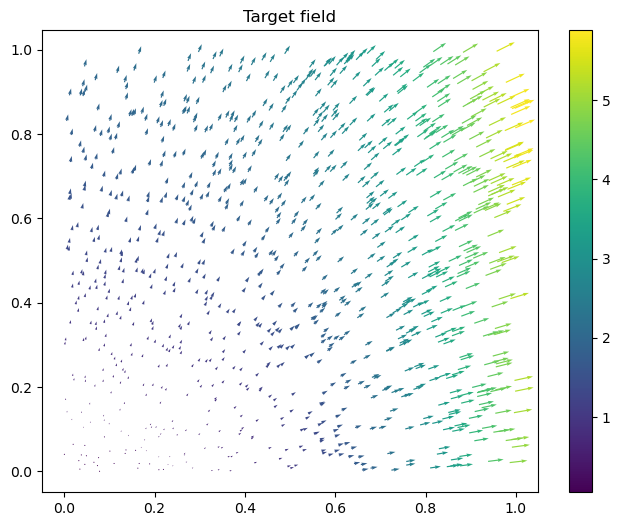

In [15]:
# Plot field (gradient)
space = torch.rand(size=(1000,2)).cpu()
fig,ax = plt.subplots(1,1,figsize=(8,6))

z = g(space)
p = ax.quiver(space[:,0],space[:,1], z[:,0],z[:,1],z.norm(dim=1))
ax.set_title('Target field')
plt.colorbar(p)
plt.show()

In [11]:
def train_gradient_field(mod,num_epochs=10000,dim=2,batch_size=100,lr=1e-2):
    optimizer = torch.optim.Adam(mod.parameters(),lr=lr)
    for i in range(num_epochs):
        input = torch.rand(size=(batch_size,dim))
        out = mod(input)
        target = g(input)

        loss = (out - target).abs().sum() / batch_size

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if not i % 1000: print("epoch", i, "loss", loss.item())

In [13]:
model_MMGN = MMGN(input_dim, output_dim, 1, hidden_dim=4)
model_CMGN = CMGN(input_dim, output_dim, 2, hidden_dim=2)

dim = 2
bsize = 100
epochs = 10000

print("Training C-MGN...")
# summary_model(model_CMGN)
train_gradient_field(model_CMGN,num_epochs=epochs,dim=dim,batch_size=bsize)

print("Training M-MGN...")
# summary_model(model_MMGN)
train_gradient_field(model_MMGN,num_epochs=epochs,dim=dim,batch_size=bsize)

Training C-MGN...
epoch 0 loss 1.845552722767647
epoch 1000 loss 0.4612783360845411
epoch 2000 loss 0.3966544994417272
epoch 3000 loss 0.3599200115841498
epoch 4000 loss 0.3762411326863634
epoch 5000 loss 0.41965068966856517
epoch 6000 loss 0.37030969734848745
epoch 7000 loss 0.40492615061730663
epoch 8000 loss 0.36814076346262053
epoch 9000 loss 0.3338566888551772
Training M-MGN...
epoch 0 loss 2973.45221066541
epoch 1000 loss 0.45721111698023725
epoch 2000 loss 0.4056143089358385
epoch 3000 loss 0.42360340741867275
epoch 4000 loss 0.44138438083753373
epoch 5000 loss 0.42608948210916825
epoch 6000 loss 0.4490623049260499
epoch 7000 loss 0.38384386670593756
epoch 8000 loss 0.42698287441245925
epoch 9000 loss 0.4938979257591634


In [14]:
# Visualize the learned field

## 3. Optimal coupling
We consider the classical Monge problem of transporting a gaussian distribution to another one under the Euclidian cost. Here we choose as in [1] the target distribution to be the standard gaussian one.

We can solve this problem minimizing different losses:
- the Wasserstein cost that has a closed form for 2 gaussians
- the transport cost between source to prediction
- the KL divergence between prediction and target 